# loading packages 

In [4]:
#!pip install evaluate
#!pip install tensorflow
#!pip install tf_keras

In [5]:


import pandas as pd
import nltk
import matplotlib 
from transformers import DistilBertForSequenceClassification, TrainingArguments, Trainer
import evaluate
import numpy as np
import torch.nn as nn
import tensorflow as tf
import tf_keras as keras
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from datasets import Dataset, Features, Value, ClassLabel, Sequence
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoConfig



# Data Processing

## Berkeley Data Loading & Preprocessing

In [6]:



berkeley = pd.read_parquet("hf://datasets/ucberkeley-dlab/measuring-hate-speech/measuring-hate-speech.parquet")

columns_relevant =  ['hatespeech', 'text', 'target_race_asian', 'target_race_black', 'target_race_latinx', 'target_race_middle_eastern',
'target_race_native_american', 'target_race_pacific_islander', 'target_race_white', 'target_religion_atheist', 'target_religion_buddhist',
'target_religion_christian', 'target_religion_hindu', 'target_religion_jewish', 'target_religion_mormon', 'target_religion_muslim', 
'target_religion_other', 'target_origin_immigrant', 'target_origin_migrant_worker', 'target_origin_undocumented', 
'target_gender_men', 'target_gender_non_binary', 'target_gender_transgender_men', 'target_gender_transgender_unspecified',
'target_gender_transgender_women', 'target_gender_women', 'target_sexuality_bisexual', 'target_sexuality_gay', 'target_sexuality_lesbian',
'target_sexuality_straight', 'target_sexuality_other', 'target_disability_physical', 'target_disability_cognitive',
'target_disability_neurological', 'target_disability_visually_impaired', 'target_disability_hearing_impaired', 'target_disability_unspecific',
'target_disability_other']

berkeley_columns_relevant = berkeley[columns_relevant]
berkeley_columns_relevant.head()

,hatespeech,text,target_race_asian,target_race_black,target_race_latinx,target_race_middle_eastern,target_race_native_american,target_race_pacific_islander,target_race_white,target_religion_atheist,...,target_sexuality_lesbian,target_sexuality_straight,target_sexuality_other,target_disability_physical,target_disability_cognitive,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other
0,0.0,Yes indeed. She sort of reminds me of the elde...,True,True,True,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
1,0.0,The trans women reading this tweet right now i...,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2.0,Question: These 4 broads who criticize America...,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0.0,It is about time for all illegals to go back t...,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2.0,For starters bend over the one in pink and kic...,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Non-Hate Text Removal

In [7]:
berkely_hate = berkeley_columns_relevant[berkeley_columns_relevant['hatespeech'] > 0]
berkely_hate



,hatespeech,text,target_race_asian,target_race_black,target_race_latinx,target_race_middle_eastern,target_race_native_american,target_race_pacific_islander,target_race_white,target_religion_atheist,...,target_sexuality_lesbian,target_sexuality_straight,target_sexuality_other,target_disability_physical,target_disability_cognitive,target_disability_neurological,target_disability_visually_impaired,target_disability_hearing_impaired,target_disability_unspecific,target_disability_other
2,2.0,Question: These 4 broads who criticize America...,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2.0,For starters bend over the one in pink and kic...,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,2.0,Who the fuck is this insignificant simple mind...,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
7,2.0,Fuck off you insufferable retarded faggot.,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,2.0,"Worthless whore, these tits with look nice wit...",False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135523,1.0,"Lady in the back Blinks when ""her"" camera red ...",False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
135546,1.0,🔥PUBG JAPAN SERIES 🔥Grade2 Day2 6/7 <Round8> 1...,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
135547,1.0,لا تتشمت الرجال مسكين يعاني كس امه 😂. يقول يال...,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
135548,1.0,#DSSUpliftsTheThirdGender #EmancipationOfEunuc...,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Demographic Column Condensing

In [8]:
lgb_cols = [ 'target_sexuality_bisexual', 'target_sexuality_gay', 'target_sexuality_lesbian', 'target_sexuality_other']

t_cols = ['target_gender_transgender_men', 'target_gender_transgender_unspecified','target_gender_transgender_women']

disability_cols = ['target_disability_physical', 'target_disability_cognitive', 'target_disability_neurological',
'target_disability_visually_impaired', 'target_disability_hearing_impaired', 'target_disability_unspecific', 'target_disability_other']

immigrant_cols = ['target_origin_immigrant', 'target_origin_migrant_worker', 'target_origin_undocumented']


berkely_hate.loc[:, 'Transgender'] = berkely_hate[t_cols].any(axis=1)
berkely_hate.loc[:, 'LGB+'] = berkely_hate[lgb_cols].any(axis=1)
berkely_hate.loc[:, 'Disabled'] = berkely_hate[disability_cols].any(axis=1)
berkely_hate.loc[:, 'Immigrant'] = berkely_hate[immigrant_cols].any(axis=1)


berkely_hate = berkely_hate.copy()
berkely_hate.rename(columns={'target_race_asian': 'Asian', 'target_race_black': 'Black', 'target_race_latinx': 'Latinx', 
'target_race_middle_eastern': 'Middle Eastern', 'target_race_pacific_islander': 'Pacific Islander', 'target_race_white': 'White', 
'target_religion_atheist': 'Atheist', 'target_religion_buddhist': 'Buddhist', 'target_religion_christian':'Christian','target_religion_hindu': 'Hindu', 
'target_religion_jewish': 'Jewish','target_religion_mormon': 'Mormon',
'target_religion_muslim': 'Muslim', 'target_religion_other': 'Other Religion', 'target_gender_men': 'Men', 
'target_gender_non_binary': 'Non-Binary', 'target_gender_women': 'Women', 'target_sexuality_straight': 'Straight', 'target_race_native_american': 'Native American',
}, inplace=True)

berkeley_compressed = berkely_hate.drop(lgb_cols + t_cols + disability_cols + immigrant_cols, axis=1)

berkeley_compressed['hatespeech'] = berkeley_compressed['hatespeech'].apply(lambda x: 1 if x > 0 else 0)
berkeley_compressed

/var/folders/cs/44q29fgn0fl61146hvy__h8h0000gn/T/ipykernel_40254/2584169070.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  berkely_hate.loc[:, 'Transgender'] = berkely_hate[t_cols].any(axis=1)
/var/folders/cs/44q29fgn0fl61146hvy__h8h0000gn/T/ipykernel_40254/2584169070.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  berkely_hate.loc[:, 'LGB+'] = berkely_hate[lgb_cols].any(axis=1)
/var/folders/cs/44q29fgn0fl61146hvy__h8h0000gn/T/ipykernel_40254/2584169070.py:13: SettingWithCopyWarning: 
A value is 

,hatespeech,text,Asian,Black,Latinx,Middle Eastern,Native American,Pacific Islander,White,Atheist,...,Muslim,Other Religion,Men,Non-Binary,Women,Straight,Transgender,LGB+,Disabled,Immigrant
2,1,Question: These 4 broads who criticize America...,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,1,For starters bend over the one in pink and kic...,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
6,1,Who the fuck is this insignificant simple mind...,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
7,1,Fuck off you insufferable retarded faggot.,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
9,1,"Worthless whore, these tits with look nice wit...",False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135523,1,"Lady in the back Blinks when ""her"" camera red ...",False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
135546,1,🔥PUBG JAPAN SERIES 🔥Grade2 Day2 6/7 <Round8> 1...,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
135547,1,لا تتشمت الرجال مسكين يعاني كس امه 😂. يقول يال...,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
135548,1,#DSSUpliftsTheThirdGender #EmancipationOfEunuc...,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Demographic Distribution Visualization

,Asian,Black,Latinx,Middle Eastern,Native American,Pacific Islander,White,Atheist,Buddhist,Christian,...,Mormon,Other Religion,Men,Non-Binary,Women,Straight,LGB+,Transgender,Disabled,Immigrant
Hate,3651,13699,4370,4464,679,696,3692,254,202,1173,...,237,599,3038,484,10693,1484,7804,1497,2365,5586


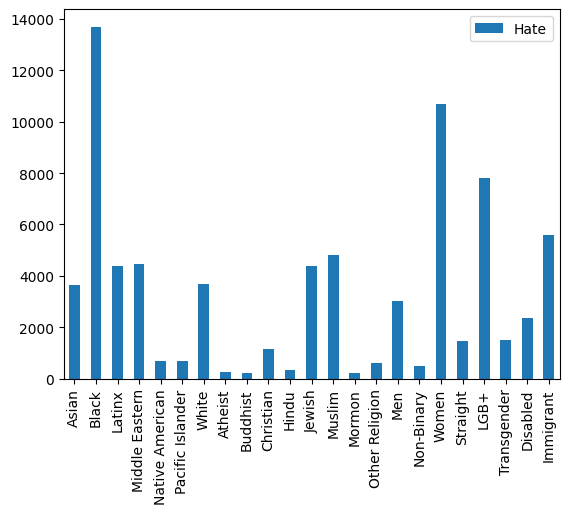

In [9]:
columns_to_sum = ['Asian', 'Black', 'Latinx', 'Middle Eastern', 'Native American', 'Pacific Islander', 'White', 'Atheist', 'Buddhist', 'Christian','Hindu', 'Jewish', 'Muslim', 'Mormon', 'Other Religion', 'Men', 'Non-Binary', 'Women', 'Straight', 'LGB+','Transgender', 'Disabled', 'Immigrant']






hate_counts = berkeley_compressed[columns_to_sum].where(berkeley_compressed['hatespeech'] == 1).sum().to_frame().T


hate_counts.index = ['Hate']


hate_counts.T.plot.bar(stacked=True)
hate_counts.head()


### Multi-Label to Multi-Class

### Removing Low-Frequency Demographics

In [10]:
#removing native american, pacific islander, athiest, buddhist,  hindu, mormon, other religions, non-binary
high_frequency_targets = berkeley_compressed.drop(['Native American', 'Pacific Islander', 'Atheist', 'Buddhist', 
                                                     'Hindu', 'Mormon', 'Other Religion', 'Non-Binary', 'Straight'], axis = 1)
high_frequency_targets

,hatespeech,text,Asian,Black,Latinx,Middle Eastern,White,Christian,Jewish,Muslim,Men,Women,Transgender,LGB+,Disabled,Immigrant
2,1,Question: These 4 broads who criticize America...,False,False,False,False,False,False,False,False,False,False,False,False,False,True
4,1,For starters bend over the one in pink and kic...,False,False,False,False,False,False,False,False,False,True,False,False,False,False
6,1,Who the fuck is this insignificant simple mind...,False,False,False,False,True,False,False,False,False,False,False,False,False,False
7,1,Fuck off you insufferable retarded faggot.,False,False,False,False,False,False,False,False,False,False,False,True,False,False
9,1,"Worthless whore, these tits with look nice wit...",False,False,False,False,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135523,1,"Lady in the back Blinks when ""her"" camera red ...",False,False,False,False,False,False,False,False,False,False,False,True,False,False
135546,1,🔥PUBG JAPAN SERIES 🔥Grade2 Day2 6/7 <Round8> 1...,False,False,False,False,False,False,False,False,False,False,False,False,False,False
135547,1,لا تتشمت الرجال مسكين يعاني كس امه 😂. يقول يال...,False,False,False,False,False,False,False,False,False,False,False,False,False,False
135548,1,#DSSUpliftsTheThirdGender #EmancipationOfEunuc...,False,False,False,True,False,False,False,False,False,False,False,False,False,False


### Multi-Labeled Demographic Removal

In [11]:
num_identities = high_frequency_targets.loc[:,"Asian":"Immigrant"].sum(axis = 1)
#print(num_identities)
num_identities

multi_identities = num_identities > 1
no_identities = num_identities == 0

berkely_dropped_none =high_frequency_targets[~no_identities]
berkely_dropped_multi = berkely_dropped_none[~multi_identities]

berkely_dropped_multi

/var/folders/cs/44q29fgn0fl61146hvy__h8h0000gn/T/ipykernel_40254/868952246.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  berkely_dropped_multi = berkely_dropped_none[~multi_identities]


,hatespeech,text,Asian,Black,Latinx,Middle Eastern,White,Christian,Jewish,Muslim,Men,Women,Transgender,LGB+,Disabled,Immigrant
2,1,Question: These 4 broads who criticize America...,False,False,False,False,False,False,False,False,False,False,False,False,False,True
4,1,For starters bend over the one in pink and kic...,False,False,False,False,False,False,False,False,False,True,False,False,False,False
6,1,Who the fuck is this insignificant simple mind...,False,False,False,False,True,False,False,False,False,False,False,False,False,False
7,1,Fuck off you insufferable retarded faggot.,False,False,False,False,False,False,False,False,False,False,False,True,False,False
9,1,"Worthless whore, these tits with look nice wit...",False,False,False,False,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135406,1,"Lady in the back Blinks when ""her"" camera red ...",False,False,False,False,False,False,False,False,False,False,False,True,False,False
135435,1,"Lady in the back Blinks when ""her"" camera red ...",False,False,False,False,False,False,False,False,False,False,True,False,False,False
135515,1,"Lady in the back Blinks when ""her"" camera red ...",False,False,False,False,False,False,False,False,False,False,True,False,False,False
135523,1,"Lady in the back Blinks when ""her"" camera red ...",False,False,False,False,False,False,False,False,False,False,False,True,False,False


### Multi-Class Training Dataset Transformation

In [12]:

#multi_class_dummy = high_frequency_targets.astype(int)
multi_class_column = pd.from_dummies(berkely_dropped_multi.loc[:,'Asian':'Immigrant'])
multi_class_column

,
2,Immigrant
4,Women
6,White
7,LGB+
9,Women
...,...
135406,LGB+
135435,Transgender
135515,Transgender
135523,LGB+


In [13]:
multi_class = pd.concat([berkely_dropped_multi,multi_class_column], axis = 1)
multi_class

,hatespeech,text,Asian,Black,Latinx,Middle Eastern,White,Christian,Jewish,Muslim,Men,Women,Transgender,LGB+,Disabled,Immigrant,
2,1,Question: These 4 broads who criticize America...,False,False,False,False,False,False,False,False,False,False,False,False,False,True,Immigrant
4,1,For starters bend over the one in pink and kic...,False,False,False,False,False,False,False,False,False,True,False,False,False,False,Women
6,1,Who the fuck is this insignificant simple mind...,False,False,False,False,True,False,False,False,False,False,False,False,False,False,White
7,1,Fuck off you insufferable retarded faggot.,False,False,False,False,False,False,False,False,False,False,False,True,False,False,LGB+
9,1,"Worthless whore, these tits with look nice wit...",False,False,False,False,False,False,False,False,False,True,False,False,False,False,Women
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135406,1,"Lady in the back Blinks when ""her"" camera red ...",False,False,False,False,False,False,False,False,False,False,False,True,False,False,LGB+
135435,1,"Lady in the back Blinks when ""her"" camera red ...",False,False,False,False,False,False,False,False,False,False,True,False,False,False,Transgender
135515,1,"Lady in the back Blinks when ""her"" camera red ...",False,False,False,False,False,False,False,False,False,False,True,False,False,False,Transgender
135523,1,"Lady in the back Blinks when ""her"" camera red ...",False,False,False,False,False,False,False,False,False,False,False,True,False,False,LGB+


In [14]:
multi_class.columns.values[16] = "label"

multi_class

,hatespeech,text,Asian,Black,Latinx,Middle Eastern,White,Christian,Jewish,Muslim,Men,Women,Transgender,LGB+,Disabled,Immigrant,label
2,1,Question: These 4 broads who criticize America...,False,False,False,False,False,False,False,False,False,False,False,False,False,True,Immigrant
4,1,For starters bend over the one in pink and kic...,False,False,False,False,False,False,False,False,False,True,False,False,False,False,Women
6,1,Who the fuck is this insignificant simple mind...,False,False,False,False,True,False,False,False,False,False,False,False,False,False,White
7,1,Fuck off you insufferable retarded faggot.,False,False,False,False,False,False,False,False,False,False,False,True,False,False,LGB+
9,1,"Worthless whore, these tits with look nice wit...",False,False,False,False,False,False,False,False,False,True,False,False,False,False,Women
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135406,1,"Lady in the back Blinks when ""her"" camera red ...",False,False,False,False,False,False,False,False,False,False,False,True,False,False,LGB+
135435,1,"Lady in the back Blinks when ""her"" camera red ...",False,False,False,False,False,False,False,False,False,False,True,False,False,False,Transgender
135515,1,"Lady in the back Blinks when ""her"" camera red ...",False,False,False,False,False,False,False,False,False,False,True,False,False,False,Transgender
135523,1,"Lady in the back Blinks when ""her"" camera red ...",False,False,False,False,False,False,False,False,False,False,False,True,False,False,LGB+


In [15]:
berkely_dropped_multi.iloc[7]

hatespeech                                                        1
text              Dwight Howard is a undercover Faggot, this guy...
Asian                                                         False
Black                                                         False
Latinx                                                        False
Middle Eastern                                                False
White                                                         False
Christian                                                     False
Jewish                                                        False
Muslim                                                        False
Men                                                           False
Women                                                         False
Transgender                                                   False
LGB+                                                           True
Disabled                                        

## Arabic Data Reading

In [30]:
arabic_data = pd.read_csv('levantine_arabic.csv',sep = ",")
arabic_data

,Tweet,Class,english
0,الوزير جبران باسيل تاج راسك يا جربان ممنوع بعد...,abusive,"Minister Gebran Bassil, crown your head, O Sco..."
1,صديقي انت ابن جامعه اللعبه اكبر من داعش اللعبه...,normal,"My friend, you are a university student. The g..."
2,و مصلحة لبنان تبدأ باستخراج النفط و الغاز لوقف...,normal,Lebanon’s interest begins with extracting oil ...
3,وليد جنبلاط كاتب الحكمة يا قذر,abusive,"Walid Jumblatt, writer of wisdom, filthy"
4,شو بتلبقلك كلمة خنزير بتجي مفصله على قياسك وشكلك,abusive,What do you think about the word “pig” that is...
...,...,...,...
5841,أمير المليشيا مش خائن,normal,The militia prince is not a traitor
5842,صدقت يناسبك جدا جدا,normal,"You are right, it suits you very well"
5843,لبخليني حب باسيل شغلتين,normal,Basil's love leaves me with two things
5844,ليش تيوس الإمارت والسعودية مع السوريين واليمني...,hate,Why are the goats of the Emirates and Saudi Ar...


## German Data Reading

In [ ]:
german_data = pd.read_csv('german.csv',sep = ",")
german_data

FileNotFoundError: [Errno 2] No such file or directory: 'german.csv'

## Korean Data Reading

In [31]:
korean_data = pd.read_csv('korean.csv',sep = ",")
korean_data

,comments,contain_gender_bias,bias,hate,english
0,(현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...,False,others,hate,(How the current hotel owner feels) Ah 18 I go...
1,....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...,False,none,none,....the representative of Korean beauty...so p...
2,"...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...",False,none,hate,...Naughty people...People who enjoyed other p...
3,"1,2화 어설펐는데 3,4화 지나서부터는 갈수록 너무 재밌던데",False,none,none,"Episodes 1 and 2 were awkward, but after episo..."
4,1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...,True,gender,hate,1. Scratching a person’s face with a fingernai...
...,...,...,...,...,...
7891,힘내세요~ 응원합니다!!,False,none,none,Cheer up~ I’m rooting for you!!
7892,힘내세요~~삼가 고인의 명복을 빕니다..,False,none,none,Cheer up~~ I pray that the deceased rest in pe...
7893,힘내세용 ^^ 항상 응원합니닷 ^^ !,False,none,none,Cheer up ^^ I will always support you ^^!
7894,힘내소...연기로 답해요.나도 53살 인데 이런일 저런일 다 있더라구요.인격을 믿습...,False,none,none,Cheer up... I'll answer with acting. I'm 53 ye...


### Korean Hate Speech Visualization

<Axes: xlabel='hate'>

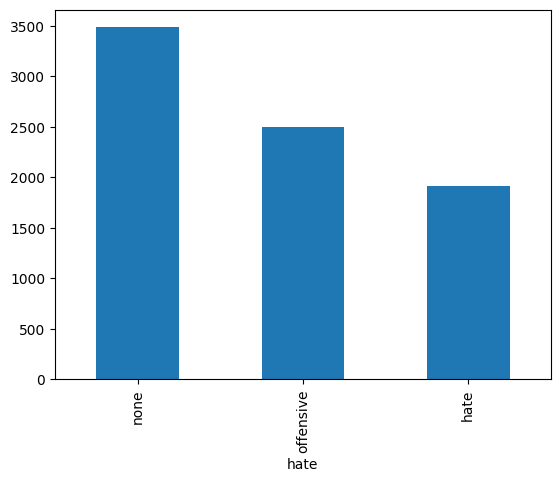

In [32]:
korean_hate_counts = korean_data['hate'].value_counts()
korean_hate_counts.plot.bar()

# Multi-Class BERT Model Training

In [44]:
multi_class = multi_class.rename(columns={'multi_class': 'label'})

encoder = LabelEncoder()
multi_class['label'] = encoder.fit_transform(multi_class['label'])



train_test = Dataset.from_pandas(multi_class).train_test_split(test_size=0.1)

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess(examples):
    tokenized = tokenizer(examples["text"], truncation=True)
    tokenized["labels"] = examples["label"]
    return tokenized

tokenized_data = train_test.map(preprocess, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/34744 [00:00<?, ? examples/s]

Map:   0%|          | 0/3861 [00:00<?, ? examples/s]

## Model Training/Tuning

In [40]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=14, problem_type="single_label_classification")



accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
precision = evaluate.load("precision")
recall = evaluate.load("recall")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="hatespeech_classifier",
    learning_rate=4e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    warmup_ratio=0.1,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/cs/44q29fgn0fl61146hvy__h8h0000gn/T/ipykernel_40254/2639983234.py:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

In [43]:
results = trainer.evaluate(tokenized_data['test'])
pd.DataFrame(results, index=['Fine-tuned DistilBERT'])

,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
Fine-tuned DistilBERT,0.50717,0.852667,12.2887,244.127,15.299,1.0


# Hate Speech Demographic Classification

## general

In [28]:
def predict_category(text):

    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)

    predict_input = tokenizer(text,
    truncation=True,
    padding=True,
    return_tensors="pt")

    predict_input = {key: value.to(device) for key, value in predict_input.items()}

    model.eval()
    with torch.no_grad():
        output = model(**predict_input)
        logits = output.logits
        prediction_value = torch.argmax(logits, dim=1).item()
        
    return prediction_value

13

In [ ]:
unlabelled_data = unlabelled_df[‘data’].to_list()
len(unlabelled_data)

In [ ]:
unlabelled_predictions = []
for data in unlabelled_data:
    unlabelled_predictions.append(predict_category(data))
    prediction_df = pd.DataFrame({
        "data": unlabelled_data,
        "labels": unlabelled_predictions,
    })
prediction_df.to_csv("model_prediction.csv", index=False)

## Arabic Predictions

In [34]:
arabic_en = arabic_data['english'].to_list()
len(arabic_en)

5846

In [37]:
arabic_predictions = []
for data in arabic_en:
    arabic_predictions.append(predict_category(data))
arabic_prediction_df = pd.DataFrame({
        "english": arabic_en,
        "labels": arabic_predictions,
    })
arabic_prediction_df.to_csv("arabic_model_prediction.csv", index=False)

## German Predictions

In [ ]:
german_en = german_data['english'].to_list()
len(german_en)

In [ ]:
german_predictions = []
for data in german_en:
    arabic_predictions.append(predict_category(data))
german_prediction_df = pd.DataFrame({
        "english": german_en,
        "labels": german_predictions,
    })
german_prediction_df.to_csv("german_model_prediction.csv", index=False)

## Korean Predictions

In [ ]:
korean_en = korean_data['english'].to_list()
len(korean_en)

In [ ]:
korean_predictions = []
for data in korean_en:
    korean_predictions.append(predict_category(data))
korean_prediction_df = pd.DataFrame({
        "english": korean_en,
        "labels": korean_predictions,
    })
korean_prediction_df.to_csv("korean_model_prediction.csv", index=False)